# Generating Synthetic Wind Power Time Series

In [1]:
import os
import re
import yaml
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import clean_data
import utils

In [117]:
config = utils.load_config("config.yaml")

dir = config['data']['wind_dir']
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)

params = config['synth']

adj_params = config['adjustable_wind_params']

_, wind_features = clean_data.relevant_features(params=params)

In [118]:
station = '00596'
file = f'Station_{station}.csv'

data = pd.read_csv(os.path.join(dir, file), delimiter= ",")
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)
#df['timestamp'] = df['timestamp'].dt.tz_convert("Europe/Berlin")
data.set_index('timestamp', inplace=True)
data = data[wind_features]

# power curve & cp curve data
power_curve = pd.read_csv(turbine_path)
power_curve = power_curve[["wind_speed",adj_params["turbine"]]]
power_curve.rename(columns={adj_params["turbine"]: "power"} ,inplace=True)
power_curve['power'] = power_curve['power'] * 1000

cp_curves = pd.read_csv(cp_path, sep=";", decimal=".")
cp_curves = cp_curves.set_index("Turbine").T
cp_curves.index = pd.to_numeric(cp_curves.index, errors='coerce')

turbine_specs = pd.read_csv(specs_path)
turbine_row = turbine_specs[turbine_specs['Turbine'] == adj_params['turbine']]
rotor_diameter = float(turbine_row["Rotordurchmesser"].iloc[0].strip("'"))
hub_height = float(turbine_row['Nabenhöhe'].iloc[0])
adj_params['rotor_diameter'] = rotor_diameter
adj_params['hub_height'] = hub_height

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87840 entries, 2023-07-24 00:00:00+00:00 to 2025-03-24 23:50:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FF_10   87791 non-null  float64
 1   TT_10   87811 non-null  float64
 2   RF_10   87811 non-null  float64
 3   SLO_10  87764 non-null  float64
 4   PP_10   87820 non-null  float64
dtypes: float64(5)
memory usage: 4.0 MB


In [120]:
station_id = re.split(r'[_\.]', file)[-2]

print(f'Station ID: {station_id}')
#data.drop(irrelevant_features, axis=1, inplace=True)

Station ID: 00596


### Analysis of missing values

In [121]:
data.isna().sum()

FF_10     49
TT_10     29
RF_10     29
SLO_10    76
PP_10     20
dtype: int64

In [122]:
missing_per_column_per_day = data.groupby(data.index.date).apply(lambda x: x.isna().sum())
missing_per_column_per_day[(missing_per_column_per_day != 0).any(axis=1)]

,FF_10,TT_10,RF_10,SLO_10,PP_10
2023-07-27,9,0,0,9,0
2023-08-14,0,0,0,2,0
2023-10-14,0,0,0,1,0
2023-11-28,0,0,0,2,0
2023-12-21,0,0,0,4,0
2024-01-07,0,0,0,1,0
2024-03-26,0,0,0,4,0
2024-03-27,0,0,0,1,0
2024-04-15,0,0,0,1,0
2024-05-14,0,0,0,1,0


We can try to impute with KNNImputer

To help KNNImputer estimating the temporal saisonalities we add encoded temporal features.

In [123]:
data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)
data['month_sin'] = np.sin(2 * np.pi * data.index.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data.index.month / 12)

We have to determine the optimal number of neighbors in beforehand.

In [124]:
# to be done

In [125]:
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data)
df = pd.DataFrame(scaler.inverse_transform(imputer.fit_transform(df_scaled)), columns=data.columns, index=data.index)
df.drop(['hour_sin', 'hour_cos', 'month_sin', 'month_cos'], axis=1, inplace=True)

In [126]:
df

,FF_10,TT_10,RF_10,SLO_10,PP_10
timestamp,,,,,
2023-07-24 00:00:00+00:00,4.8,16.8,89.6,1.1,1001.1
2023-07-24 00:10:00+00:00,4.8,16.7,89.8,1.0,1001.0
2023-07-24 00:20:00+00:00,4.4,16.6,89.9,1.2,1001.0
2023-07-24 00:30:00+00:00,4.9,16.6,90.7,1.1,1000.9
2023-07-24 00:40:00+00:00,4.7,16.7,90.0,0.9,1000.8
...,...,...,...,...,...
2025-03-24 23:10:00+00:00,1.5,4.5,91.6,0.2,1013.8
2025-03-24 23:20:00+00:00,2.0,4.6,90.1,0.4,1013.8
2025-03-24 23:30:00+00:00,2.7,4.3,91.6,0.2,1013.7


### Saturation state

Since not all vapor quantities mix with the non-condensing gas, three states must be distinguished:

- <b>Unsaturated</b>: Only the gas phase, namely the gas-vapor mixture, is present. The partial pressure of the vapor $ p_w $ is lower than the saturation vapor pressure $ p_s $. With the partial pressure of the gas $ p_g $ the total pressure can be determined with $ p = p_g + p_d $.
  
- <b>Saturated</b>: In the gas-vapor mixture the condensation begings. The partial pressure of the vapor is equal to saturation vapor pressure $ p_s = p_w $ . 
  
- <b>Over saturated</b>: There are gas and condensate phases, whereby the gas phase (the gas-vapor mixture) is saturated. The relationships of the saturated state apply to the gas phase.

### Composition of moist air

A distinction is made between absolute and relative humidity, whereby both measure the the H<sub>2</sub>O in the vapor phase.

<b>Absolute humidity</b>: Only with respect to the vapor, fog or ice fog is not considered. The absolute humidity is identical with the partial density of water vapor $ \varrho_d $:

$ \varrho_w = \frac{m_w}{V_{Mi}} = \frac{p_w}{R_{H_20}T}$, 

where 
- $ m_w $ is the mass of the water vapor,
- $ V_{Mi} $ is the volume of the gas mixture,
- $ R_{H_2O} $ is the specific gas constant for water,
- $ T $ is the temperature of the mixture.

In the saturated state $ p_s = p_d $ it is the saturation parital density $ \varrho_s $:

$ \varrho_s = \frac{p_s}{R_{H_20}T}$.

### Relative humidity $ \phi $ 
is defined as:

$ \phi = \frac{\varrho_w}{\varrho_s} = \frac{p_{w}}{p_s} $

with:
- $ \phi $: Relative humiditiy 
- $ p_w $: Partial pressure of water vapor in the air (Pa)
- $ p_s $: Saturation vapor pressure (Pa)

The saturation vapor pressure $ p_s $ is the maximal partial pressur for the water at given temperature $ T $. A higher $ p_s $ is not possible, because the additional water will condense to liquid or disublimate to solid water (ice). 

Relative humidity $ \phi $ can take numerical values in the range $ 0 \leq \phi \leq 1 $. That means:

- $ \phi = 0 $ is dry air,
- $ \phi < 1 $ is unsaturated moist air,
- $ \phi = 1 $ is saturated moist air ($ m_{kon} = 0 $)
- $ \phi = 1 $ is oversaturated moist air ($ m_{kon} > 0 $).


### Get air density from air pressure, temperature and relative humidity

Since we need the density of the air, we need to determine the pressure and gas constant values for the mixture of dry air and water vapor.

The air density is therefore dependent from the partial density of the water vapor $ \varrho_w $ and the partial density of the dry air denoted as $ \varrho_g $, where $ g $ stands for gas.

$ \rho = \varrho_g + \varrho_w = \frac{p_g}{R_gT} + \frac{p_w}{R_{H_2O}T} $

where $ R_g $ is the specific gas constant for dry air.

The specific gas constants are given with:

- $ R_g = 287.05 \frac{J}{kgK} $
- $ R_{H_2O} = 461.5 \frac{J}{kgK} $

The partial water vapor pressure is given by first calculating the saturation vapor pressure (Huang, 2018):
https://journals.ametsoc.org/view/journals/apme/57/6/jamc-d-17-0334.1.xml

$ p_s = \exp\left(34.4942 - \frac{4924.99}{t + 237.1}\right) \cdot (t + 105)^{1.57} (t > 0°C) $

$ p_s = \exp\left(43.4942 - \frac{6545.8}{t + 278}\right) \cdot (t + 868)^{-2} (t \leq 0°C) $

With the relative humidity the partial water vapor pressure can be determined:

$ p_w = \phi * p_s $

The remaining variable $ p_g $ is calculated by subtracting $ p_g $ from the air pressure $ p $:

$ p_g = p - p_w $


### Extrapolate wind speed at hub height
https://ieeexplore.ieee.org/abstract/document/8255215

There are different methods to extrapolate the wind speed at hub height in the literature.

<b>The log-linear law</b> is based on the Monin-Obukhov similarity theory, it is a physical model stating that the wind velocity at a determined height $ h_2 $ can be calculated by:

$ v_2 = v_1 \cdot \frac{\ln\left(\frac{h_2}{z_0}\right) - \psi_m\left(\frac{h_2}{L}\right)}{\ln\left(\frac{h_1}{z_0}\right) - \psi_m\left(\frac{h_1}{L}\right)} $

- $v_2$: Wind speed to be calculated at the height $h_2$ (m/s).
- $v_1$: Wind speed measured at anemometer height $h_1$ (m/s).
- $h_2$: Target height where the wind speed is to be calculated (m).
- $h_1$: Height of the anemometer where the wind speed is measured (m).
- $z_0$: Roughness length, describing the influence of surface roughness on the wind profile (m).
- $\psi_m$: Monin-Obukhov stability function, accounting for atmospheric stability.
- $L$: Monin-Obukhov length (m), representing the thermal and dynamic properties of the atmospheric boundary layer.

But in engineering studies, the log-linear law is difficult to use for estimating vertical wind profile at a wind turbine height, among others because Monin-Obukhov stability function is dependend on the temperature difference between the heights, which is often not known.

In the case of neutral stability ($ \psi_m = 0 $), the log-linear law can be simplifies to the widely used logarithmic law which depends only on $ z_0 $ and is valid near the ground over relatively flat terrain (the lower 30-50 m), but not over complex and rough terrain (Gualtieri, 2011, 2015):

$ v_2 = v_1 \cdot \frac{\ln\left(\frac{h_2}{z_0}\right)}{\ln\left(\frac{h_1}{z_0}\right)} $

<b>The power law</b> is generally used (Tizgui, 2017).

Let $ v_1 $ be the measurement of the wind speed at height $ h_1 $ and $ v_2 $ be the wind speed at height $ h_2 $:

$ \frac{v_2}{v_1} = (\frac{h_2}{h_1})^{\alpha} $

where $ \alpha $ is the Hellmann (or friction) exponent, also known as the power exponent, depending on wind speed, atmospheric stability, land features, height and surface roughness.

It is obtained empirically (Schallenberg-Rodriguez, 2013). 

It has no phyiscal basis and its validity is generally limited to the lower atmosphere (up to 150-200 m), (Gualtieri, 2015).

<b>Estimating alpha</b>

There are different methods to estimate $ \alpha $, but the most used is C. G. Justus et al. (1976):

$ \alpha = \frac{0.37 - 0.0881 \ln(v_1)}{1 - 0.0881 \ln\left(\frac{h_1}{10}\right)} $

They have shown graphically that for $ v \geq 10 \frac{m}{s} $ the exponent $ \alpha $ is closely to 0.14 = 1/7.

Is is often supposed for neutral stability (high wind) cases in flat terrain. 

Research on this topic is rare, but Gualtieri made a comprehensive review on wind resource extrapolation models in 2019, considering 96 locations worldwide.

Gualtieri demonstrated in 2015 that the exponent $ \alpha_{12} $ between $ z_1 $ and $ z_2 $ is linearly related to the surface turbulence intensity $ I_1 $ at $ z_1 $ (Ishizaki mentioned this first in 1983 for neutral conditions at 15 m for $ v \geq 10 m/s $):

$ \alpha_{12} = b I_1 $

where I is the ratio between wind speed standard deviation ($ \sigma_u $) and wind speed mean ($ \hat{v} $):

$ I = \frac{\sigma_u}{\hat{v}} $

with both $ \sigma_u $ and $ \hat{v} $ calculated over 10-min bins, while $ b $ is a stability dependent linear regression coefficient.

$ b = \frac{1}{\kappa A_u} $

where $ \kappa $ is the von Karman's constant, typically set to 0.4 and $ A_u $ is the ratio of $ \sigma_u $ and $ u_* $.

$ u_* $ is the friction velocity in m/s, which can be determined by:

$ u_* = \left[\overline{(wu)^2} + \overline{(wv)^2}\right]^{1/4} = \left(\frac{\lvert \tau_z \rvert}{\rho_a}\right)^{1/2} $ (Jacobson, 2005, p. 231)

where $ w $ is the vertical, $ u $ is the zonal (west-east) and $ v $ the meridional (north-south) wind speed.

$ \lvert \tau_z \rvert$ is the magnitude of the vertical turbulent flux of horizontal momentum.

$ \rho_a = \rho_d + \rho_v $ is the mass density of moist air (Jacobson, 2005, p. 33).

It turned out, that normalized bias (NB) was the lowest with 4 %, compared to constantly assuming $ \alpha $ to be 1/7 with NB = 19.6 \%.

### Pressure and density at altitude

Pressure decreases with altitude as in lower atmospheric layers there is more air mass above acting a force on the air below.

The standard barometric altitude formula is outdated as it assumes an isothermal atmosphere. In practice, however, the temperature decreases with increasing altitude in the atmosphere.

The following equation is an improved barometric formula, as it incorporates the temperature change as well:</br>
https://link.springer.com/article/10.1007/s40828-020-0111-6

$ p(h_1) = p(h_0) \cdot \left(1 - \frac{a \cdot \Delta h}{T(h_0)}\right)^{\frac{M \cdot g}{R \cdot a}} $

Replacing the pressure by density following the ideal gas law results in an improved barometric formula for density at altitude $ h_1 $:

$ \rho(h_1) = \rho(h_0) \cdot \left(1 - \frac{a \cdot \Delta h}{T(h_0)}\right)^{\frac{M \cdot g}{R \cdot a} - 1} $

#### Assumption of temperature decreasing linearly

$ T(h) = T(h_0) - a \cdot \Delta h $ 

### Parameters
- $ p(h_0) $: Air pressure at reference altitude $ h_0 $ (in Pa or hPa).
- $ p(h_1) $: Air pressure at altitude $ h_1 $ (in Pa or hPa).
- $ T(h_0) $: Air temperature at reference height $ h_0 $ (in Kelvin).
- $ T(h) $: Air temperature at altitude $ h $ (in Kelvin).
- $ a $: Vertical temperature gradient.
- $ \Delta h = h_1 - h_0 $: Height difference (in Meters).
- $ M = 0.028949 \, \mathrm{kg/mol} $: Average molar mass of dry air in lower layers.
- $ R = 8.31451 \, \mathrm{J/(kg \cdot K)} $: Universal gas constant.
- $ g = 9.81 \, \mathrm{m/s^2} $: .

In [127]:
def get_windspeed_at_height(data: pd.DataFrame,
           params: dict,
           adj_params: dict
          ):
    
    """
    Calculate the wind speed (v2) using different methods.

    Parameters:
    -----------
    data : pd.DataFrame
    params: dict
        Dictionary with parameters names
        params['v_wind']['param']: Wind Speed
        params['d_wind']['param']: Wind Direction
        params['w_wind']['param']: Vertical Wind Speed
        params['sigma_wind_lon']['param']: Standard Deviation longitudinal wind speed
    adj_params : dict
        Dictionary with neccesary parameters
        adj_params['h1']: Height of measurements in m
        adj_params['h2']: Hub height in m
        adj_params['karman']: von Karmans constant
        adj_params['method']: Height of measurement in m
            The method used to calculate v2. Options are:
            - 'alphaI': Uses linear relationship between turbulence intensity and alpha (Ishizaki, 1983) 
            - 'seven_power': A default method using the 1/7 power law.
            If no method is provided, the default 'seven_power' is used.
    Returns:
    --------
    v2 : float
        The calculated wind speed at height h2.
    """
    v1 = data[params['v_wind']['param']]
    
    method = adj_params['v2_method']
    h1 = adj_params['h1']
    h2 = adj_params['hub_height']
    
    if method == 'alphaI':
        direction = data[params['d_wind']['param']]
        sigma_u = data[params['sigma_wind_lon']['param']]
        w = 0.3 #data[params['w_wind']['param']] as long as not vertical wind data ist available
        k = adj_params['karman']
        
        theta = (270 - direction).apply(math.radians)
        u = v1 * theta.apply(math.cos)
        v = v1 * theta.apply(math.sin)
        
        I = sigma_u / u
        u_star = ( (w*u)**2 + (w*v)**2 ) ** 1/4
        
        Au = sigma_u / u_star
        b = 1/(k*Au)
        alpha = b * I
    elif method == 'seven_power':
        alpha = 1/7
    else:
        alpha = 1/7 # 'seven_power'
    v2 = v1 * (h2 / h1) ** alpha
    return v2


def get_temperature_at_height(data: pd.DataFrame,
                              params: dict,
                              adj_params: dict) -> pd.Series:
    t1 = data[params['temperature']['param']]
    t1 = t1 + 273.15 
    h1 = 2 # in meters
    h2 = adj_params['hub_height']
    temp_gradient = adj_params['temp_gradient']
    delta_h = h2 - h1
    t2 = t1 - temp_gradient * delta_h
    return t2

    
def get_pressure_at_height(data: pd.DataFrame,
                           params: dict,
                           adj_params: dict,
                           h1: float) -> pd.Series:
    R = 8.31451
    M_air = 0.028949 # dry air
    g = 9.81
    p1 = data[params['pressure']['param']]
    t1 = data[params['temperature']['param']]
    t1 = t1 + 273.15
    h2 = adj_params['hub_height']
    temp_gradient = adj_params['temp_gradient']
    M = M_air # molar mass of air (including water vapor) is less than that of dry air
    delta_h = h2 - h1
    p2 = p1 * ( 1 - (temp_gradient * delta_h) / t1 ) ** ( (M * g) / (temp_gradient * R) )
    return p2

def get_density_at_height(data: pd.DataFrame,
                          params: dict,
                          adj_params: dict) -> pd.Series:
    R = 8.31451
    M_air = 0.028949 # dry air
    M_h20 = 0.018015 # water 
    g = 9.81
    rho1 = data[params['density']['param']]
    t1 = data[params['temperature']['param']]
    t1 = t1 + 273.15
    h1 = 2 # because of temperature measured at 2 m
    h2 = adj_params['hub_height']
    temp_gradient = adj_params['temp_gradient']
    M = M_air # molar mass of air (including water vapor) is less than that of dry air
    delta_h = h2 - h1
    rho2 = rho1 * ( 1 - (temp_gradient * delta_h) / t1 ) ** ( (M * g) / (temp_gradient * R) - 1)
    return rho2

def get_power_curve(data: pd.DataFrame,    
                    power_curve: pd.Series,
                    params: dict) -> pd.Series:
    wind = data[[params["v_wind_hub"]["param"]]]
    power = pd.merge(wind, power_curve,left_on = params["v_wind_hub"]["param"], right_on='wind_speed', how="left")
    power.index = wind.index
    #C_p = (power["power"]/1000) / (0.5 * rho * rotor_area * wind["v_wind_hub"]**3)
    return power['power']

def get_C_p(data: pd.DataFrame,    
            cp_curves: pd.Series, 
            params: dict,
            adj_params: dict):
    wind = data[[params["v_wind_hub"]["param"]]]
    cp_curve = cp_curves[[adj_params["turbine"]]]
    C_p = pd.merge(wind, cp_curve,left_on = params["v_wind_hub"]["param"], right_index=True, how="left")[adj_params["turbine"]]
    return C_p

def get_saturated_vapor_pressure(temperature: pd.Series,
                                 model: str = 'improved magnus') -> pd.Series:
    if model == 'huang':
        p_s = np.where(
            temperature > 0,
            np.exp(34.494 - (4924.99 / (temperature + 237.1))) / (temperature + 105) ** 1.57,
            np.exp(43.494 - (6545.8 / (temperature + 278))) / (temperature + 868) ** 2
        )
    elif model == 'improved_magnus':
        p_s = np.where(
            temperature > 0,
            610.94 * np.exp((17.625 * temperature) / (temperature + 243.04)),
            611.21 * np.exp((22.587 * temperature) / (temperature + 273.86))
    )
    return p_s
    
def get_rho(data: pd.DataFrame,
            params: dict) -> pd.Series:
    R_dry = 287.05  # Specific gas constant dry air (J/(kg·K))
    R_w = 461.5  # Specific gas constaint water vapor (J/(kg·K))
    air_pressure = data[params['pressure']['param']]
    temperature = data[params['temperature']['param']]
    relhum = data[params['relhum']['param']]
    p_s = data[params['sat_vap_pressure']['param']]
    # check if relative humidity is in the range between 0 and 1
    if relhum.max() > 1:
        relhum /= 100
    temperature_kelvin = temperature + 273.15 
    p_w = relhum * p_s
    p_g = air_pressure - p_w
    rho_g = p_g / (R_dry * temperature_kelvin)
    rho_w = p_w / (R_w * temperature_kelvin)
    rho = rho_g + rho_w
    return rho

def get_cut_in_cut_out_speeds(power_curve: pd.DataFrame):
    power_curve['wind_speed'] = pd.to_numeric(power_curve['wind_speed'])
    cut_in = power_curve[power_curve['power'] > 0]['wind_speed'].min()
    cut_out = next((power_curve['wind_speed'].iloc[i] for i in range(1, len(power_curve)) if power_curve['power'].iloc[i] == 0 and power_curve['power'].iloc[i - 1] > 0), None)
    return cut_in, cut_out

def get_features(data: pd.DataFrame,
                 cp_curves: pd.DataFrame,
                 params: dict,
                 adj_params: dict) -> pd.DataFrame:
    data[params['v_wind_hub']['param']] = round(get_windspeed_at_height(data=data,
                                                                  params=params,
                                                                  adj_params=adj_params), 2)
    data[params['temperature_hub']['param']] = get_temperature_at_height(data=data,
                                                                         params=params,
                                                                         adj_params=adj_params)
    temperature = data[params['temperature']['param']]
    data[params['sat_vap_pressure']['param']] = get_saturated_vapor_pressure(temperature=temperature,
                                                                             model=adj_params['p_s_model'])
    temperature_hub = data[params['temperature_hub']['param']]
    data[params['sat_vap_pressure_hub']['param']] = get_saturated_vapor_pressure(temperature=temperature_hub,
                                                                                 model=adj_params['p_s_model'])
    data[params['density']['param']] = get_rho(data=data,
                                               params=params)
    data[params['density_hub']['param']] = get_density_at_height(data=data,
                                                                 params=params,
                                                                 adj_params=adj_params)
    
    '''                                                         
    data[params["C_p"]["param"]] = get_C_p(data=df,
                                           cp_curves=cp_curves,
                                           params=params,
                                           adj_params=adj_params)
    '''
    data[params["power_curve"]["param"]] = get_power_curve(data=df,
                                                           power_curve=power_curve,
                                                           params=params)
    return data

def generate_wind_power(data: pd.DataFrame,
                        power_curve: pd.DataFrame,
                        params: dict,
                        adj_params: dict
                        ) -> pd.DataFrame:
    rated_power = power_curve["power"].max()  # Watts
    rotor_diameter = adj_params['rotor_diameter']
    Cp = adj_params["Cp"] #data[params['C_p']['param']]
    cut_in, cut_out = get_cut_in_cut_out_speeds(power_curve=power_curve)
    rated_speed = adj_params['rated_speed']
    rho = data[params['density_hub']['param']]
    wind_speed_hub = data[params['v_wind_hub']['param']]
    rotor_area = np.pi * (rotor_diameter / 2) ** 2
    wind_power = np.where(
        wind_speed_hub < cut_in, 0,
        np.where(
            wind_speed_hub <= cut_out,
            np.minimum(rated_power, 0.5 * rho * rotor_area * Cp * wind_speed_hub ** 3),
            0
        )
    )
    df[params['power']['param']] = wind_power
    return df


def plot_power_and_feature(data: pd.DataFrame,
                           params: dict,
                           day: str, 
                           feature: dict,
                           power: pd.Series,
                           save_fig=False): 
    day = pd.Timestamp(day)
    tz = power.index.tz  # Extrahiere die Zeitzone
    if tz is not None:
        day = day.tz_localize(tz) # Zeitzone zuweisen
    index_0 = power.index.get_loc(day)
    index_1 = power.index.get_loc(day + pd.Timedelta(days=1))
    feature_specs = params[feature]
    series = data[feature_specs['param']]
    feature_name = feature_specs['name']
    unit = feature_specs['unit']
    date = str(series.index[index_0:index_1][0].date())
    fig, ax1 = plt.subplots(figsize=(10, 6))
    fontsize = 14
    lines = []
    # plot power
    line1, = ax1.plot(
    power[index_0:index_1],
    label="Power Output (kW)",
    color="black",
    linewidth=2.0
    )
    lines.append(line1)
    # configure secondary y-axis
    ax1.set_xlabel("Time", fontsize=fontsize)
    ax1.set_ylabel("Power Output (kW)", fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2)
    ax2 = ax1.twinx()
    # plot feature
    line, = ax2.plot(
        series[index_0:index_1],
        label=f"{feature_name} {unit}",
        linestyle='--',
        #color='blue',
        linewidth=2.0
    )
    lines.append(line)
    # configure primary y-axis
    ax2.set_ylabel(f"{feature_name} ({unit})", fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    # Format x-axis to show only hours (HH)
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ticks = ax1.get_xticks()
    ax1.set_xticks(ticks[1:-1])
    # legend
    lines.append(lines.pop(0))
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=fontsize)
    plt.title(f"{feature_name} and Power Output on {date}", fontsize=fontsize)
    fig.tight_layout()
    #plt.grid(True)
    if save_fig:
        save_path = f'figs/{feature_name}'
        os.makedirs(save_path, exist_ok=True)
        save_file = os.path.join(save_path, f'{date}.png')
        plt.savefig(save_file, dpi=300)
        plt.close()
    else:
        plt.show()


In [128]:
df = get_features(data=df,
                  cp_curves=cp_curves,
                  params=params,
                  adj_params=adj_params)

df = generate_wind_power(data=df,
                            power_curve=power_curve,
                            params=params, 
                            adj_params=adj_params)

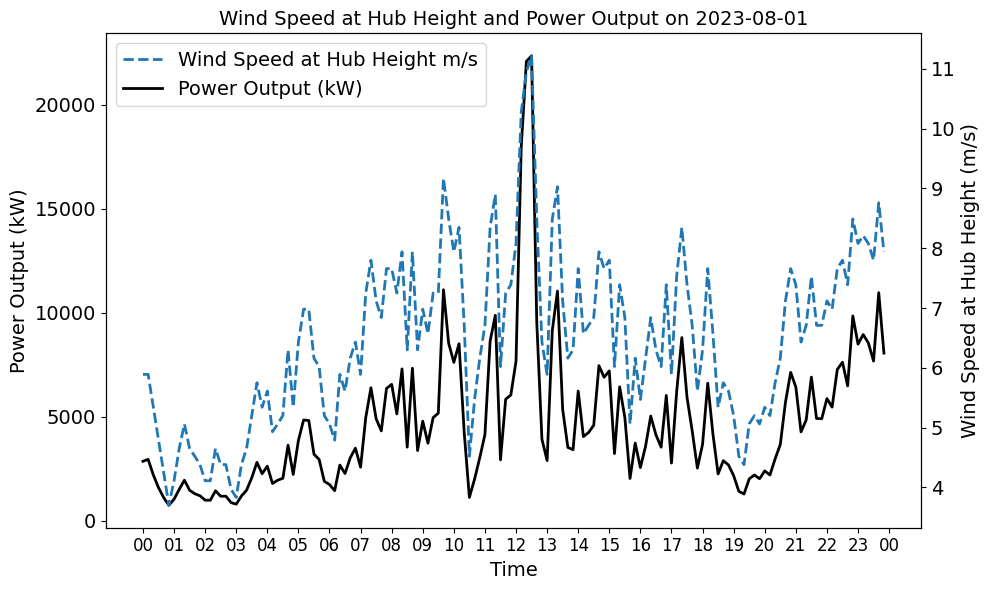

In [129]:
day = '2023-08-01'
feature='v_wind_hub'
plot_power_and_feature(data=df,
                        params=params,
                        day=day,
                        feature=feature,
                        power=df[params['power']['param']])      

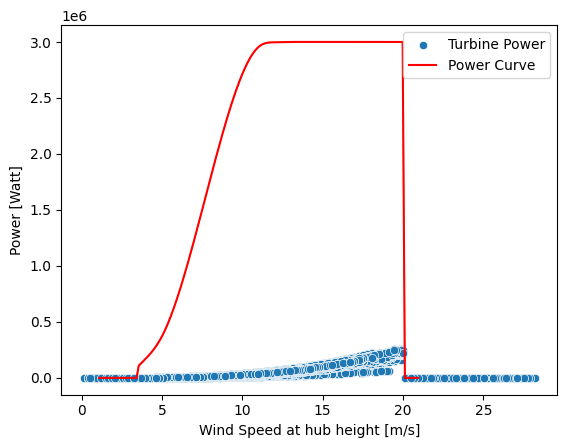

In [130]:
sns.scatterplot(x=df[params['v_wind_hub']['param']], y=df[params['power']['param']], label='Turbine Power')
sns.lineplot(x=df[params['v_wind_hub']['param']], y=df[params['power_curve']['param']], color='red', label='Power Curve')

plt.xlabel('Wind Speed at hub height [m/s]')
plt.ylabel('Power [Watt]')
plt.legend()

plt.show()